In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import math
import seaborn as sns
import warnings
from scipy.stats import zscore
warnings.filterwarnings('ignore')

try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import functions_module as fn
    
def event_based_MI(cohort_epochs, trial_min, std):
    rewarded_types = []
    for t in ['rewarded hit','rewarded FA']:
        for prefix in ['Tactile ','Auditory ']:
            rewarded_types.append(prefix+t)

    unrewarded_types = []
    for t in ['unrewarded hit','unrewarded FA']:
        for prefix in ['Tactile ','Auditory ']:
            unrewarded_types.append(prefix+t)

    response_types = []
    for t in ['unrewarded hit','rewarded hit','unrewarded FA','rewarded FA']:
        for prefix in ['Tactile ','Auditory ']:
            response_types.append(prefix+t)

    noresponse_types = []
    for t in ['unrewarded CR','unrewarded miss']:
        for prefix in ['Tactile ','Auditory ']:
            noresponse_types.append(prefix+t)  

    sns.set()
    mods = {}
    for stage in ['N','E']:
        modulated_ROIs = {}
        for epoch, mod_label, ttypes in zip(['response','reward'], [['responses','no responses'],['rewarded','unrewarded']], [[response_types, noresponse_types],[rewarded_types, unrewarded_types]]):
            modulated_ROIs[epoch] = {}
            epoch_events = pd.concat(cohort_epochs['events'][epoch])
            epoch_deltaF = pd.concat(cohort_epochs['deltaF'][epoch])
            for channel in ['Red','Green']:
    #             fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,1.5), sharex=True, sharey=True)
                channel_events = epoch_events[epoch_events.Channel == channel]
                channel_deltaF = epoch_deltaF[epoch_deltaF.index.get_level_values('Channel') == channel]

                col = 0
                for prot in ['dis','rev']:
                    protocol = stage+prot
                    protocol_events = channel_events[channel_events.Protocol == protocol]
                    protocol_deltaF = channel_deltaF[channel_deltaF.index.get_level_values('Protocol') == protocol]

                    rates = {}
                    for target_types, other_types, labels in zip([ttypes[0], ttypes[1]], [ttypes[1], ttypes[0]], ['pos','neg']):
                        target_events = protocol_events[(protocol_events['Final Outcome'].isin(target_types))]
                        target_ROIs = target_events.groupby([target_events['Unique_ROI'], target_events.index.get_level_values(0)]).size()
                        other_events = protocol_events[(protocol_events['Final Outcome'].isin(other_types))]
                        other_ROIs = other_events.groupby([other_events['Unique_ROI'], other_events.index.get_level_values(0)]).size()

                        target_deltaF = protocol_deltaF[(protocol_deltaF.index.get_level_values('Final Outcome').isin(target_types))]
                        target_trials = target_deltaF.groupby([target_deltaF.index.get_level_values('Unique_ROI'), target_deltaF.index.get_level_values(0)]).size()
                        other_deltaF = protocol_deltaF[(protocol_deltaF.index.get_level_values('Final Outcome').isin(other_types))]
                        other_trials = other_deltaF.groupby([other_deltaF.index.get_level_values('Unique_ROI'), other_deltaF.index.get_level_values(0)]).size()

                        ## Replace rows where trial numbers < trial_min with nan ##
                        target_df = pd.concat([target_ROIs, target_trials], axis=1)
                        target_df[0] = np.where(target_df[1] < trial_min, np.nan, target_df[0])
                        other_df = pd.concat([other_ROIs, other_trials], axis=1) 
                        other_df[0] = np.where(other_df[1] < trial_min, np.nan, other_df[0])

                        ## calculate event rate ##
                        target_df['rate'] = target_df[0] / target_df[1]
                        other_df['rate'] = other_df[0] / other_df[1]

                        # Fill event rate where trial numbers < trial_min with nan ##
                        target_df['rate'] = np.where(target_df[1] < trial_min, np.nan, target_df['rate'])
                        other_df['rate'] = np.where(other_df[1] < trial_min, np.nan, other_df['rate'])

                        # Fill nan event rate where trial numbers >= trial_min with zero ##
                        target_df['rate'] = np.where(((target_df['rate'].isna()) & (target_df[1] >= trial_min)), 0, target_df['rate'])
                        other_df['rate'] = np.where(((other_df['rate'].isna()) & (other_df[1] >= trial_min)), 0, other_df['rate'])  

                        target_rate = target_df[['rate']]
                        other_rate = other_df[['rate']]      
                        rate_df = pd.concat([target_rate, other_rate], axis=1)
                        rate_df.columns = [0,1]
                        rates[labels] = rate_df

                    for mod, mod_df in rates.items():
                        suffix = '+ve' if col in [0,2] else '-ve'
                        dict_label = mod_label[0] if col in [0,2] else mod_label[1]

                        ## Assign the mean event rates for ROIs where there are < min_trials, only on the other rate (i.e. not the target rate) ##
                        mod_df['target rate'] = mod_df[0]
                        mod_df['other rate'] = np.where(mod_df[1].isna(), mod_df[1].mean(), mod_df[1])
                        mod_df = mod_df[~((mod_df[0].isna()) & (mod_df[1].isna()))] #drop rows where there are not < min_trials for both trial types 

                        mod_df['MI'] = ((mod_df['target rate'] - mod_df['other rate']) / (mod_df['target rate'] + mod_df['other rate']))
                        mod_df['MI scaled'] = mod_df['MI'] * ((mod_df['target rate']+mod_df['other rate'])/2) #scale MI by average rate across both trial types
                        mod_df['MI'] = np.where((mod_df[0] == 0) & (mod_df[1] == 0), 0, mod_df['MI']) #assign zero if both event rates are zero
                        mod_df['MI scaled'] = np.where((mod_df[0] == 0) & (mod_df[1] == 0), 0, mod_df['MI scaled']) #assign zero if both event rates are zero

                        ## Convert MI values to array ##
                        MI_df = mod_df[['MI scaled']].dropna()
                        MI = MI_df.to_numpy()

                        ## Calculate MI threshold ##
                        median = np.median(MI)
                        mean = np.mean(MI)
#                         std = (factor*(np.std(MI)))
                        thresh = round(std,3)

                        nmodulated = 0
                        for ID in MI_df.index.get_level_values(1).unique():
                            ID_df = MI_df[MI_df.index.get_level_values(1) == ID]
                            ID_df = ID_df[ID_df['MI scaled'] > std]
                            nmodulated += ID_df.shape[0]
                            if dict_label not in modulated_ROIs[epoch].keys():
                                modulated_ROIs[epoch][dict_label] = {}
                                if ID not in modulated_ROIs[epoch][dict_label].keys():
                                    modulated_ROIs[epoch][dict_label][ID] = ID_df.index.get_level_values(0).to_list()
                                else:
                                    modulated_ROIs[epoch][dict_label][ID] = modulated_ROIs[epoch][dict_label][ID] + ID_df.index.get_level_values(0).to_list()       
                            else:
                                if ID not in modulated_ROIs[epoch][dict_label].keys():
                                    modulated_ROIs[epoch][dict_label][ID] = ID_df.index.get_level_values(0).to_list()
                                else:
                                    modulated_ROIs[epoch][dict_label][ID] = modulated_ROIs[epoch][dict_label][ID] + ID_df.index.get_level_values(0).to_list()

    #                     ax[col].hist(MI, bins=12, alpha=0.7, density=True)
    #                     ax[col].axvline(std)
    #                     ax[col].set_xlim(-0.6,0.6)
    #                     ax[col].set_ylim(0,12)
    #                     ax[col].text(s=f'{nmodulated} ROIs above {thresh}', 
    #                                  x=ax[col].get_xlim()[1], y=ax[col].get_ylim()[1],
    #                                  fontsize=8, horizontalalignment='right', verticalalignment='top')
    #                     ax[col].set_title(f'{epoch} {suffix} ({protocol})', fontsize=10)
                        col += 1

    #             fig.suptitle(f'{channel}', fontsize=12, y=1.1)
    #             plt.show();
            mods[stage] = modulated_ROIs

    lick_positive_ROIs = []
    rew_positive_ROIs = []
    rew_negative_ROIs = []
    for stage, stage_dict in mods.items():
        lick_positive_ROIs = lick_positive_ROIs + [item for key, sublist in stage_dict['response']['responses'].items() for item in sublist]
        rew_positive_ROIs = rew_positive_ROIs + [item for key, sublist in stage_dict['reward']['rewarded'].items() for item in sublist]
        rew_negative_ROIs = rew_negative_ROIs + [item for key, sublist in stage_dict['reward']['unrewarded'].items() for item in sublist]
    rew_negative_neutral_ROIs = [x for x in valid_ROIs if x not in rew_positive_ROIs]
    # correct_response_ROIs = [item for key, sublist in modulated_ROIs['response']['correct responses'].items() for item in sublist]
    # unexpected_reward_ROIs = [item for key, sublist in modulated_ROIs['reward']['unexpected reward'].items() for item in sublist]
    # uncorrelated_ROI_list = [x for x in valid_ROIs if x not in correlated_ROI_list]
    
    return mods, lick_positive_ROIs, rew_positive_ROIs, rew_negative_ROIs, rew_negative_neutral_ROIs

In [46]:
data_directory = fn.set_data_directory(r'C:\Users\61407\Desktop\Current analysis\Project 3') #directory where all of the data is stored
cohort_epochs = fn.upload_cohort_epochs(data_directory)

mouse_IDs = cohort_epochs['deltaF']['all'].keys()                         
nmice = len(mouse_IDs) #number of mice in the directory for later plotting purposes
random_colors = cm.rainbow(np.linspace(0,1,nmice)) #get array of random colors (nmice = number of different colors)    

ID_colors = {}
for i, (mouse) in enumerate(mouse_IDs):
    ID_colors[mouse] = random_colors[i]
    
all_metrics = np.load(data_directory+'\\'+'all_metrics.npy', allow_pickle=True).item()
extracted_behavior = np.load(data_directory+'\\extracted_behavior.npy', allow_pickle=True).item()

GCaMP_POm_Batch3_five events_epochs.npy
RGECO_GCamP_Batch1_four events_epochs.npy
RGECO_GCamP_Batch1_muji events_epochs.npy
RGECO_GCamP_Batch2_five events_epochs.npy
RGECO_GCamP_Batch2_three RGECO_GCamP_Batch2_three_events_epochs.npy
RGECO_GCamP_Batch3_muji events_epochs.npy
RGECO_GCamP_Batch3_three events_epochs.npy
GCaMP_POm_Batch3_five deltaF_epochs.npy
RGECO_GCamP_Batch1_four deltaF_epochs.npy
RGECO_GCamP_Batch1_muji deltaF_epochs.npy
RGECO_GCamP_Batch2_five deltaF_epochs.npy
RGECO_GCamP_Batch2_three RGECO_GCamP_Batch2_three_deltaF_epochs.npy
RGECO_GCamP_Batch3_muji deltaF_epochs.npy
RGECO_GCamP_Batch3_three deltaF_epochs.npy
RGECO_GCamP_Batch1_four pupil_epochs.npy
RGECO_GCamP_Batch1_muji pupil_epochs.npy
RGECO_GCamP_Batch2_five pupil_epochs.npy
RGECO_GCamP_Batch2_three RGECO_GCamP_Batch2_three_pupil_epochs.npy
RGECO_GCamP_Batch3_muji pupil_epochs.npy
RGECO_GCamP_Batch3_three pupil_epochs.npy


In [47]:
licks = {}
for root, dirs, files in os.walk(data_directory):
    for f in files:
        if ('aligned_data.npy' in f) & ('Old version' not in root):
            ID = f.split('_aligned')[0]
            file = np.load(root+'\\'+f, allow_pickle=True).item()
            licks[ID] = {}
            
            for protocol, protocol_dict in file.items():
                for date, date_dict in protocol_dict.items():
                    for FOV, FOV_dict in date_dict.items():
                        for channel, channel_df in FOV_dict.items():
                            df = channel_df[['Trial licks','Post-trial licks','Water','stimtype']]
                            unique_session = ('_').join([protocol, date, FOV])
                            licks[ID][unique_session] = df

In [48]:
extracted_behavior = {}
reversed_sessions = {}
for dtype, dtype_dict in cohort_epochs.items():
    if dtype != 'events': #only use deltaF and pupil data because events data does not contain behavioral trials with no events
        extracted_behavior[dtype] = {}
        single_trial_behavior = []
        sesh_by_sesh_behavior = []
        epoch_dict = dtype_dict['all'] #only use one epoch instead of looping through epoch and repeating the same process
        for ID, ID_df in epoch_dict.items():
            ID_df = ID_df.dropna(how='all') #drops all trials where every sample is a nan value
            if ID_df.shape[0] == 0: #drops sessions where there are 0 trials
                None
            else:
                ## Only use data from one ROI/channel per session (i.e. don't need to duplicate the same behavioral trial) ##
                for sesh in ID_df.index.get_level_values('Unique session').unique():
                    sesh_df = ID_df[ID_df.index.get_level_values('Unique session') == sesh]
                    if dtype == 'pupil':
                        first_channel = sesh_df.index.get_level_values('Channel')[0]
                        sesh_df = sesh_df[sesh_df.index.get_level_values('Channel') == first_channel]
                    else:
                        first_ROI = sesh_df.index.get_level_values('Unique_ROI')[0]
                        sesh_df = sesh_df[sesh_df.index.get_level_values('Unique_ROI') == first_ROI]
                        
                    ## Only use data from sessions where there is more than 1 trial type and 30 trials ##
                    if (len(sesh_df.index.get_level_values('Trial type').unique()) > 1) & (sesh_df.shape[0] >= 30):
                        protocol = sesh_df.index.get_level_values('Protocol')[0]
                        posteriors_df = pd.DataFrame(fn.calculate_posteriors(sesh_df, sesh_df.shape[0], protocol, dtype)[0]) #get post-hoc stimulus/response/reward rates
                        
                        ## These are probably sessions where the trialtype labels were reversed (i.e. Go=NoGo, hit=FA, etc...) ##
                        if (posteriors_df['reward prob']['G'] - posteriors_df['reward prob']['N'] < -0.2) | (posteriors_df['rare prob']['G'] > 1.2):
                            
                            ## Note down which sessions required reversal of labels in dict ##
                            if ID not in reversed_sessions.keys():
                                reversed_sessions[ID] = []
                                reversed_sessions[ID].append(sesh)
                            else:
                                reversed_sessions[ID].append(sesh)
                            
                            ## Reverse outcomes and run "fn.calculate_posteriors" function again ##
                            reversed_outcomes = fn.reverse_outcomes(sesh_df)
                            sesh_df['reversed outcomes'] = reversed_outcomes
                            sesh_df = sesh_df.assign(d=reversed_outcomes).set_index('reversed outcomes', append=True)
                            posteriors_df = pd.DataFrame(fn.calculate_posteriors(sesh_df, sesh_df.shape[0], protocol, dtype)[0])
                        
                        ## Cleanup dataframe to only include relevant data ##
                        sesh_df = sesh_df.reset_index()[list(sesh_df.index.names)] #removes calcium/pupil metrics from dataframe to only retain behavioral data
                        sesh_df['ID'] = [ID]*sesh_df.shape[0] #add mouse ID
                        sesh_df = sesh_df.set_index(['ID','Unique session','Protocol','Unique_trial', sesh_df.columns[(sesh_df.shape[1]-2)]]) #set index columns
                        if dtype == 'deltaF':
                            sesh_df = sesh_df.iloc[:,[5,6,7,8,11]] #column numbers of interest (i.e. licking metrics) - check that the column numbers are correct
                        else:
                            sesh_df = sesh_df.iloc[:,[4,5,6,7,10]] #column numbers of interest (i.e. licking metrics) - check that the column numbers are correct
                        sesh_df['Response latency'] = sesh_df['Response latency'].replace({'-':3500}).astype(float) 
                        sesh_df['Response latency'] = (sesh_df['Response latency']/1000)-3 #convert response latency to seconds from stimulus onset
                        sesh_df['Timeout_end'] = sesh_df.iloc[:,4].replace({'-':8000}).astype(float)
                        sesh_df['Timeout_end'] = (sesh_df['Timeout_end']/1000) #convert ITI time to seconds
                        sesh_df = sesh_df.reset_index() #drop index columns to data columns
                        sesh_df = sesh_df.rename({sesh_df.columns[4]:'Final Outcome'}, axis=1) #make final column name consistent (instead of some sessions being "reversed outcomes")
                        sesh_df['Trial'] = [int(x.split('_')[-1]) for x in list(sesh_df['Unique_trial'])]
                        sesh_df = sesh_df.set_index('Trial')
                        
                        ## Find relevant lick data for current session and recount ##
                        if sesh not in licks[ID].keys():
                            None #these sessions are not in "aligned_data.npy" files so they are not included
                        else:
                            lick_df = licks[ID][sesh]
                            sesh_df = pd.concat([sesh_df, lick_df], axis=1)
                            recounted_licks = fn.recount_licks(sesh_df)
                            final_df = sesh_df[['ID', 'Unique session', 'Unique_trial', 'Protocol', 'Final Outcome', 'Water','stimtype',
                                                'Response latency', 'Timeout_end', 'Trial licks','Post-trial licks']]
                            final_df = pd.concat([final_df, recounted_licks], axis=1).dropna(how='any')
                            
                            ## Add session data to relevant lists ##
                            single_trial_behavior.append(final_df) #append trial-by-trial session data to "single_trial_behavior" list
                            sesh_by_sesh_behavior.append(fn.calculate_session_rates(posteriors_df, final_df, sesh, protocol, dtype, ID)) #append session averaged data to "sesh_by_sesh" list
        
        ## Concatenate list of dataframes and store in one dictionary variable, as well as save each file as csv in data directory ##
        for df_list, label in zip([single_trial_behavior, sesh_by_sesh_behavior], ['single_trial','sesh_by_sesh']):
            df = pd.concat(df_list)
            extracted_behavior[dtype][label] = df
            df.to_csv(data_directory+'\\'+dtype+'_'+label+'_behavior.csv')
np.save(data_directory+'\\extracted_behavior.npy', extracted_behavior, allow_pickle=True)
np.save(data_directory+'\\reversed_sessions.npy', reversed_sessions, allow_pickle=True)

In [49]:
rthresh = -1
event_thresh = 0
time_thresh = 15

## Plot the traces of correlated ROI pairs and save metrics to .npy file, if the plot pdfs already exist in the data directory for the above parameter settings ##
fn.plot_and_extract_correlated_ROIs(cohort_epochs['deltaF']['all'], cohort_epochs['events']['all'], rthresh, event_thresh, time_thresh)

## Upload the correlated ROI pairs metrics .npy file from data directory for the above parameter settings ##
correlated_ROIs = np.load(data_directory+'\\correlated_ROIs_'+str(rthresh)+'rthresh_'+str(time_thresh)+'timethresh_'+str(event_thresh)+'eventthresh.npy', allow_pickle=True).item()
list_of_lists = [list(correlated_ROIs[y].keys()) for y in [x for x in list(correlated_ROIs.keys())]]
correlated_ROI_list = [item for sublist in list_of_lists for item in sublist]

correlated_ROIs_-1rthresh_15timethresh_0eventthresh.npy already exists


In [50]:
all_trialtypes = {'correct responses': ['rewarded hit', 'unrewarded hit'],
                 'incorrect responses': ['rewarded FA', 'unrewarded FA'],
                 'unexpected omission': ['unrewarded hit', 'unrewarded hit'],
                 'expected omission': ['unrewarded FA', 'unrewarded FA'],
                 'expected reward': ['rewarded hit', 'rewarded hit'],
                 'unexpected reward': ['rewarded FA', 'rewarded FA'],
                 'unexpected outcomes': ['unrewarded hit', 'rewarded FA'],
                 'expected outcomes': ['unrewarded FA', 'rewarded hit'],
                 'responses':['rewarded hit','rewarded FA','unrewarded hit','unrewarded FA'],
                 'no responses':['unrewarded miss','unrewarded CR'],
                 'rewarded responses':['rewarded hit','rewarded FA'],
                 'unrewarded responses':['unrewarded hit','unrewarded FA']}

In [51]:
modulation_trialtypes = {'correct responses':['hit','FA'],
              'incorrect responses':['FA','hit'],
              'unexpected omission':['unrewarded hit','unrewarded FA'],
              'expected omission':['unrewarded FA','unrewarded hit'],
              'expected reward':['rewarded hit','rewarded FA'],
              'unexpected reward':['rewarded FA','rewarded hit'],
              'Go':['Go', 'NoGo'],
              'NoGo':['NoGo', 'Go'],
              'responses':['hit', 'FA'],
              'no responses':['CR','miss'],
              'rewarded':['rewarded', 'unrewarded'],
              'unrewarded':['unrewarded', 'rewarded'],
              'unexpected outcomes':['unrewarded hit','rewarded FA'],
              'expected outcomes':['unrewarded FA','rewarded hit']
             }

boxplot_colors = {'unexpected omission':'magenta',
          'expected omission':'grey',
          'expected reward':'navy',
          'unexpected reward':'lightblue',
          'Hit':'green',
          'correct responses':'green',
          'Miss':'grey',
          'FA':'darkred',
          'incorrect responses':'darkred',
          'CR':'darkorange',
          'expected outcomes': 'grey',
          'unexpected outcomes': 'magenta',
          'Go':'navy',
          'NoGo':'grey',
          'rewarded responses':'blue',
          'unrewarded responses':'darkorange',
          'responses':'darkcyan',
          'no responses':'olive'}

trace_colors = {'unexpected omission':'magenta',
          'expected omission':'peru',
          'expected reward':'navy',
          'unexpected reward':'lightblue',
          'correct responses':'green',
          'Miss':'grey',
          'incorrect responses':'darkred',
          'Correct Rejections':'darkorange',
          'expected outcomes': 'black',
          'unexpected outcomes': 'magenta',
          'Go':'navy',
          'NoGo':'grey',
          'rewarded responses':'blue',
          'unrewarded responses':'darkorange',
          'responses':'darkcyan',
          'no responses':'olive'}

task_phases = {'Ndet':'Novice association',
               'Edet':'Expert association',
               'Ndis':'Novice pre-reversal',
               'Edis':'Expert pre-reversal',
               'Nrev':'Novice post-reversal',
               'Erev':'Expert post-reversal'}

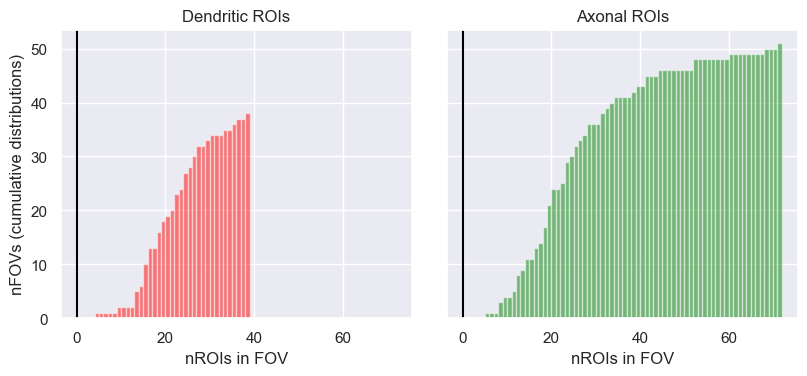

In [52]:
all_df = pd.concat(cohort_epochs['deltaF']['all'])
nROIs = {}
for sesh in all_df.index.get_level_values('Unique session').unique():
    sesh_df = all_df[all_df.index.get_level_values('Unique session') == sesh]
    for channel in sesh_df.index.get_level_values('Channel').unique():
        channel_df = sesh_df[sesh_df.index.get_level_values('Channel') == channel]
        ROIs = channel_df.groupby(channel_df.index.get_level_values('Unique_ROI')).mean().shape[0]
        if channel not in nROIs.keys():
            nROIs[channel] = {}
            nROIs[channel][sesh] = ROIs
        else:
            nROIs[channel][sesh] = ROIs

ROI_thresh = 0
valid_ROIs = []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.34*1.5, 2.5*1.5), sharey=True, sharex=True, gridspec_kw={'wspace':0.1})
for col, (channel, label, color) in enumerate(zip(['Red','Green'], ['Dendritic ROIs','Axonal ROIs'], ['red','green'])):
    channel_ROIs = nROIs[channel]
    ax[col].hist(channel_ROIs.values(), bins=max(channel_ROIs.values())-min(channel_ROIs.values()), color=color,alpha=0.5, cumulative=True)
    if col == 0:
        ax[col].set_ylabel('nFOVs (cumulative distributions)')
    ax[col].set_xlabel('nROIs in FOV')
    ax[col].axvline(ROI_thresh, color='black')
    ax[col].set_title(label)
    
    for sesh, n in channel_ROIs.items():
        if n >= ROI_thresh:
            valid_df = all_df[all_df.index.get_level_values('Unique session') == sesh]
            for ROI in valid_df.index.get_level_values('Unique_ROI').unique():
                valid_ROIs.append(ROI)
plt.show()

In [53]:
mods, lick_positive_ROIs, rew_positive_ROIs, rew_negative_ROIs, rew_negative_neutral_ROIs = event_based_MI(cohort_epochs, 3, 0.068)

pairwise_cutoff = 0.9
cutoff_on = 'maxes'
nbins = 20
filtered_ROI_dfs = fn.filter_correlated_ROIs(correlated_ROIs, pairwise_cutoff, cutoff_on, nbins)
correlated_ROI_list = pd.concat(filtered_ROI_dfs).index.get_level_values(2).tolist()

In [54]:
all_deltaF = pd.concat(cohort_epochs['deltaF']['all'])
# zscored_deltaF = all_deltaF.groupby(all_deltaF.index.get_level_values('Unique_ROI')).apply(zscore)
# single_trial_deltaF = all_deltaF.groupby([all_deltaF.index.get_level_values(0), all_deltaF.index.get_level_values('Unique_trial'), all_deltaF.index.get_level_values('Channel'), all_deltaF.index.get_level_values('Protocol'), all_deltaF.index.get_level_values('Response latency'), all_deltaF.index.get_level_values('Final Outcome')]).mean()

In [55]:
protocols = ['Edis','Nrev','Erev']
trialtypes = ['responses','no responses']#'rewarded responses','unrewarded responses']
channels = ['Red']

for ID in single_trial_deltaF.index.get_level_values(0).unique():
    ID_df = single_trial_deltaF[single_trial_deltaF.index.get_level_values(0) == ID]
    for channel in channels:
        compartment = 'Dendrites' if channel == 'Red' else 'Axons'
        if channel in ID_df.index.get_level_values('Channel'):
            channel_df = ID_df[ID_df.index.get_level_values('Channel') == channel]
            for protocol in protocols:
                protocol_name = task_phases[protocol]
                if protocol in channel_df.index.get_level_values('Protocol'):
                    protocol_df = channel_df[channel_df.index.get_level_values('Protocol') == protocol]
                    fps = 30.3 if protocol_df.dropna(axis=1).shape[0] == 367 else 30.54
                    start = math.floor(fps*2)
                    end = math.floor(fps*8)
                    
                    all_trials = []
                    for trialtype in trialtypes:
                        ttype_list = []
                        for t in all_trialtypes[trialtype]:
                            ttype_list.append('Tactile '+t)
                            ttype_list.append('Auditory '+t)
                        ttype_df = protocol_df[protocol_df.index.get_level_values('Final Outcome').isin(ttype_list)]
                        ntrials = ttype_df.shape[0]
                        all_trials.append(ntrials)
                        
                    fig, ax = plt.subplots(nrows=1, ncols=len(trialtypes), sharey=True,
                                           figsize=(0.5*len(trialtypes),0.3*max(all_trials)))
                    for col, (trialtype) in enumerate(trialtypes):
                        ttype_list = []
                        for t in all_trialtypes[trialtype]:
                            ttype_list.append('Tactile '+t)
                            ttype_list.append('Auditory '+t)
                        ntrials = ttype_df.shape[0]
                        
                        if ntrials > 4:
                            trial_ratio = ntrials/max(all_trials)

                            ttype_df = protocol_df[protocol_df.index.get_level_values('Final Outcome').isin(ttype_list)]  
                            ttype_df = ttype_df.iloc[:,:-2]
                            ttype_df = ttype_df[(ttype_df.std(axis=1) != 0) & (ttype_df.mean(axis=1) > -0.8)]
                            ttype_df = ttype_df.loc[:, start:end]
                            
                            protocol_df = protocol_df.iloc[:,2:-2] #remove shutter artifact
                            protocol_df = protocol_df[(protocol_df.std(axis=1) != 0) & (protocol_df.mean(axis=1) > -0.8)] #remove no fluorescence trials
                            protocol_df = protocol_df.loc[:, start:end]
                            protocol_range = (protocol_df.max()-protocol_df.min()).max()

#                             protocol_max = protocol_df.max().max()
#                             protocol_min = protocol_df.min().min()

#                             norm_df = (ttype_df - protocol_min) / (protocol_max - protocol_min)
                            ttype_df['peak'] = ttype_df.idxmax(axis=1)
                            ttype_df = ttype_df.sort_values('peak').iloc[:,:-1]

                            factor = 0
                            for i, (index, rows) in enumerate(ttype_df.iterrows()):
                                outcome = index[5]
                                factor += (rows.min()-protocol_range)
                                ax[col].plot(rows+factor, linewidth=0.75, color=trace_colors[trialtype], alpha=0.75)
#                                 ax[col].vlines(3*fps, ymin=(rows+factor).min(), ymax=(rows+factor).min()+protocol_range, color='darkred')

                                if ('miss' not in outcome) & ('CR' not in outcome):
                                    response_latency = index[4]
                                    response_frame = float(response_latency)/fps

                                    if 'reward' in trialtype:
                                        if 'unreward' in trialtype:
                                            ax[col].vlines(response_frame+fps, ymin=(rows+factor).min(), ymax=(rows+factor).min()+protocol_range, color='black', alpha=0.5)
                                        else:
                                            ax[col].vlines(response_frame+fps, ymin=(rows+factor).min(), ymax=(rows+factor).min()+protocol_range, color='darkcyan', alpha=0.75)
                                    else:
                                        ax[col].vlines(response_frame, ymin=(rows+factor).min(), ymax=(rows+factor).min()+protocol_range, color='darkorange', alpha=0.75)                                    
                                else:
                                    response_latencies = [float(x) for x in protocol_df[protocol_df.index.get_level_values('Response latency') != '-'].index.get_level_values('Response latency')]
                                    response_frame = np.mean(np.array(response_latencies)) / fps
                                    ax[col].vlines(response_frame, ymin=(rows+factor).min(), ymax=(rows+factor).min()+protocol_range, color='black', alpha=0.5)                                    
                            ax[col].set_title(f'{trialtype}', fontsize=8)
                            ax[col].axis('off')
                    fig.suptitle(f'{ID}\n {compartment} {protocol_name}', fontsize=10)

NameError: name 'single_trial_deltaF' is not defined

### Maybe better to visualize ROI-by-ROI traces (i.e. one waterfall plot per trial where each trace is an ROI) and can highlight event traces ##

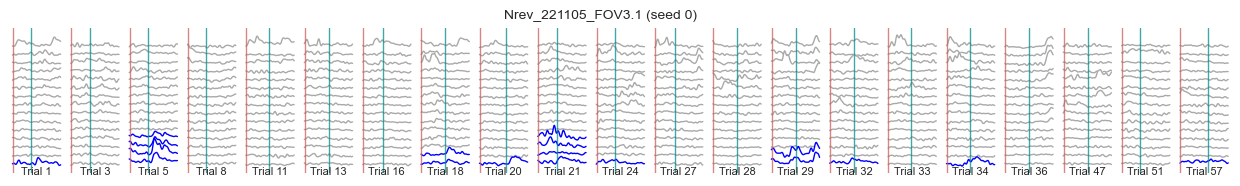

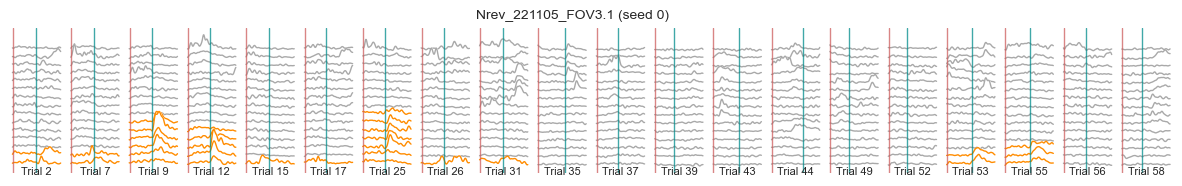

In [60]:
sessions = ['Nrev_221105_FOV3.1']#['Edis_230103_FOV2.2','Nrev_221105_FOV3.1','Erev_230105_FOV2']# ['Nrev_221105_FOV3.1','Edis_221224_FOV6.2','Erev_230105_FOV6.1']# ['Erev_230108_FOV1.1','Edis_221224_FOV6.2','Nrev_221105_FOV3.1']
seeds = [0,0,0] #[9,24,20]
protocols = ['Nrev']
trialtypes = ['rewarded responses','unrewarded responses']
channels = ['Red']

max_trials = 50
min_trials = 5

squish_factor = 2 #minimum 1 or else all traces won't fit on figure
y_shrinkage = 2 
x_range = [3,7]

scaling_dict = {'xscaling':1,
                'yscaling':1}
sort_dict = {'sort_by':['nEvents','peak'],
             'ascending':[False, False],
             'events_first':False}

all_deltaF = pd.concat(cohort_epochs['deltaF']['all'])
all_events = pd.concat(cohort_epochs['events']['all'])
# all_deltaF = all_deltaF[all_deltaF.index.get_level_values('Unique_ROI').isin(correlated_ROI_list)]
# all_events = all_events[all_events['Unique_ROI'].isin(correlated_ROI_list)]

plot_all_pulsar_traces(sessions, seeds, protocols, trialtypes, channels, 
                       max_trials, min_trials, 
                       squish_factor, y_shrinkage, x_range, 
                       scaling_dict, sort_dict,
                       all_deltaF, all_events)

In [59]:
def plot_all_pulsar_traces(sessions, seeds, protocols, trialtypes, channels, max_trials, min_trials, squish_factor, y_shrinkage, x_range, scaling_dict, sort_dict, all_deltaF, all_events):
    if sessions == 'all':
        sessions = all_deltaF.index.get_level_values('Unique session').unique()
        seeds = [0]*len(sessions)
    else:
        sessions = sessions
        seeds = seeds
    for sesh, seed in zip(sessions,seeds):
        if seed in [9,46]:
            tmax = 50
        else:
            tmax = max_trials
        np.random.seed(seed)
        sesh_df = all_deltaF[all_deltaF.index.get_level_values('Unique session') == sesh]
        for channel in channels:
            compartment = 'dendrites' if channel == 'Red' else 'axons'
            if channel in sesh_df.index.get_level_values('Channel'):
                channel_df = sesh_df[sesh_df.index.get_level_values('Channel') == channel]
                for protocol in protocols:
                    protocol_name = task_phases[protocol]
                    if protocol in channel_df.index.get_level_values('Protocol'):
                        protocol_df = channel_df[channel_df.index.get_level_values('Protocol') == protocol]

                        ## Get framerate and corresponding start/end frames ##
                        fps = 30.54 if protocol_df.dropna(axis=1).shape[0] == 367 else 30.3
                        start = math.floor(fps*x_range[0])
                        end = math.floor(fps*x_range[1])

                        for trialtype in trialtypes:                           
                            ## Get events and deltaF for current trial type of interest ##
                            epoch_events = pd.concat(cohort_epochs['events']['reward']) if ('reward' in trialtype) | ('omission' in trialtype) | ('outcomes' in trialtype) else pd.concat(cohort_epochs['events']['response'])
                            epoch_events = epoch_events[(epoch_events['Unique session'] == sesh) & (epoch_events['Channel'] == channel)]
                            ttype_df, ttype_events = extract_ttype_df(protocol_df, epoch_events, trialtype, all_trialtypes)

                            ## Bit of data cleaning ##
                            ttype_df = ttype_df.iloc[:,2:-2] #remove shutter artifact
                            ttype_df = ttype_df[ttype_df.std(axis=1) != 0] #remove no fluorescence trials
                            ttype_df[ttype_df.mean(axis=1) > -0.8] #remove no fluorescence trials
                            ttype_df = ttype_df.loc[:, start:end] #select frames for the desired view range

                            ## Determine how many trials we will plot (one trial per subplot) ##
                            ntrials = len(ttype_df.index.get_level_values('Unique_trial').unique())
                            if ntrials > (min_trials-1):
                                final_trials = tmax if tmax <= ntrials else ntrials

                                ## Randomly sample trials ##
                                subindex = ttype_df.index.get_level_values('Unique_trial').unique()
                                sample_ids = np.random.choice(subindex, final_trials, replace=False)
                                ttype_df = ttype_df[ttype_df.index.get_level_values('Unique_trial').isin(sample_ids)]

                                ## Set figure parameters using set_figure() function ##
                                n_lines = len(ttype_df.index.get_level_values('Unique_ROI').unique()) #number of lines in each subplot
                                if n_lines > 0:
                                    x = ttype_df.columns #the x-values of the lines
                                    if scaling_dict == {}:
                                        fig, ax = set_figure(n_lines, final_trials, squish_factor)
                                    else:
                                        fig, ax = set_figure(n_lines, final_trials, squish_factor,
                                                             xscaling = scaling_dict['xscaling'], yscaling = scaling_dict['yscaling'])

                                    ## Loop through each trial of current trial type dataframe (to plot every ROI for each trial) ##
                                    for col, (trial) in enumerate(ttype_df.index.get_level_values('Unique_trial').unique()):
                                        tnum = trial.split('_')[-1] #current trial number
                                        trial_df = ttype_df[ttype_df.index.get_level_values('Unique_trial') == trial] #single trial deltaF (of all ROIs)
                                        outcome = trial_df.index.get_level_values('Final Outcome')[0] #outcome of current trial number
                                        response_latency = trial_df.index.get_level_values('Response latency')[0]
                                        
                                        ## Sort rows of trial_df using sort_deltaF_rows function ##
                                        if sort_dict == {}:
                                            final_data, non_event_indexes, event_indexes = sort_deltaF_rows(trial, channel, 
                                                                                                            trial_df, all_events, ttype_events)
                                        else:
                                            final_data, non_event_indexes, event_indexes = sort_deltaF_rows(trial, channel, trial_df, 
                                                                                                            all_events, ttype_events,
                                                                                                            sort_dict['sort_by'], 
                                                                                                            sort_dict['ascending'], 
                                                                                                            sort_dict['events_first'])
                                        ## Set index-based line plotting parameters ##
                                        idx_colors = [trace_colors[trialtype] if x in event_indexes else 'darkgrey' for x in range(final_data.shape[0])]
                                        idx_alpha = [1 if x in event_indexes else 1 for x in range(final_data.shape[0])]

                                        ## Plot the resulting pulsar charts onto current axes object (ax[col]) ##
                                        ax_obj = ax[col] if final_trials > 1 else ax
                                        pulsar_plot(final_data, n_lines, x, ax_obj, 
                                                    squish_factor=squish_factor, y_shrinkage=y_shrinkage, 
                                                    axis='off', idx_colors=idx_colors, idx_alpha=idx_alpha)
                                        plot_behavioral_vlines(outcome, trialtype, response_latency, 
                                                               ax_obj, x_range, fps) # plot stimulus, lick, reward times

                                    ## Section for titles, subtitles, and figure saving ##
                                        ax_obj.set_title(f'Trial {tnum}', fontsize=8, y=0, pad=-1)
                                    fig.suptitle(f'{sesh} (seed {seed})',fontsize=10)#\n {compartment} {protocol_name} {trialtype[:-1]} trials', fontsize=10, y=0.98)
                                    fig.savefig(os.path.join(data_directory,f'WATERFALL_{sesh}_{compartment}_{trialtype}_correlated_ROIs.svg'))
                                    plt.show()

In [41]:
def pulsar_plot(final_data, n_lines, xvalues, ax_obj, squish_factor=3, y_shrinkage=2, axis='off', idx_colors='darkgrey', idx_alpha=1):
    line_mins = []
    for i, (index, rows) in enumerate(final_data.iterrows()):
        line = rows/y_shrinkage + (n_lines - i/squish_factor) #re-scale and re-position line

        ## Store minimum and maximum line values for re-adjusting y-axis limits later ##
        line_mins.append(line.min())
        
    for i, (index, rows) in enumerate(final_data.iterrows()):
        ## Recover line parameters to plot ##
        color = idx_colors[i] if idx_colors != 'darkgrey' else 'darkgrey'
        alpha = idx_alpha[i] if idx_alpha != 1 else 1
        line = rows/y_shrinkage + (n_lines - i/squish_factor) #re-scale and re-position line

        ## Plot resulting line
        if i > 0:
            ax_obj.fill_between(xvalues, line, min(line_mins), lw=1, edgecolor='white', facecolor='white', zorder=i/n_lines)
        ax_obj.plot(xvalues, line, lw=1, c=color, alpha=alpha, zorder=i/n_lines)   
    ax_obj.axis('off')

In [13]:
def set_figure(n_lines, ncols, squish_factor, wspace=0.1, sharey=True, xscaling=1, yscaling=1):
    x_size = ((0.15)*ncols)*5*xscaling
    y_size = ((n_lines*0.05)/squish_factor)*5*yscaling
    
    if ncols > 1:
        fig, ax = plt.subplots(nrows=1, ncols=ncols, sharey=sharey,
        figsize=(x_size, y_size), gridspec_kw={'wspace':wspace})
    else:
        fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    return fig, ax

In [14]:
def extract_ttype_df(df, epoch_events, trialtype, all_trialtypes):
    ttype_list = []
    for t in all_trialtypes[trialtype]:
        ttype_list.append('Tactile '+t)
        ttype_list.append('Auditory '+t)
    ttype_df = df[df.index.get_level_values('Final Outcome').isin(ttype_list)]  
    ttype_events = epoch_events[epoch_events['Final Outcome'].isin(ttype_list)]
    
    return ttype_df, ttype_events

In [15]:
def plot_behavioral_vlines(outcome, trialtype, response_latency, ax_obj, x_range, fps):
    if ('miss' not in outcome) & ('CR' not in outcome):
        response_frame = float(response_latency)/fps

        if ('reward' in trialtype) | ('omission' in trialtype) | ('outcomes' in trialtype):
            ax_obj.axvline(response_frame+fps, color='darkcyan', alpha=0.75, linewidth=1)
        else:
            ax_obj.axvline(response_frame, color='darkorange', alpha=0.75, linewidth=1)                                    
    else:
        response_frame = 3.5*fps
        ax_obj.axvline(response_frame, color='darkorange', alpha=0.75, linewidth=1)   
    ax_obj.axvline(3*fps, color='indianred', alpha=0.75, linewidth=1) if x_range[0] <= 3 else None

In [16]:
def sort_deltaF_rows(trial, channel, trial_df, all_events, ttype_events, sort_by=['nEvents','peak'], ascending=[False,False], events_first=False):
    ## Find all events for current trial and integrate into trial_df ##
    all_trial_events = all_events[all_events['Unique_trial'] == trial]
    ROI_event_counts = all_trial_events.groupby(all_trial_events['Unique_ROI']).size()
    ROI_event_counts = ROI_event_counts[ROI_event_counts.index.str.contains(channel)].to_frame()
    ROI_event_counts.index.names = ['Unique_ROI']
    ROI_event_counts.columns = ['nEvents']
    ROI_idx_df = trial_df.reset_index().set_index('Unique_ROI')
    event_integrated_trial_df = pd.concat([ROI_idx_df, ROI_event_counts], axis=1)
    event_integrated_trial_df['nEvents'] = event_integrated_trial_df['nEvents'].fillna(0)
    idx_names = [x if x != None else 'level_0' for x in list(trial_df.index.names)]
    event_integrated_trial_df = event_integrated_trial_df.reset_index().set_index(idx_names)

    ## Find epoch events for current trial and make a separate deltaF dataframe (to plot last) ## ##                               
    epoch_trial_events = ttype_events[ttype_events['Unique_trial'] == trial]
    event_ROIs = epoch_trial_events['Unique_ROI'].unique()
    event_df = event_integrated_trial_df[event_integrated_trial_df.index.get_level_values('Unique_ROI').isin(event_ROIs)]
    non_event_df = event_integrated_trial_df[~event_integrated_trial_df.index.get_level_values('Unique_ROI').isin(event_ROIs)]

    ## Calculate peak, peak_time, skew and sort by metrics of choice ##   
    event_df['peak'] = event_df.max(axis=1)
    event_df['peak_time'] = event_df.idxmax(axis=1)
    event_df['skew'] = event_df.skew(axis=1)
    
    non_event_df['peak'] = non_event_df.max(axis=1)
    non_event_df['peak_time'] = non_event_df.idxmax(axis=1)
    non_event_df['skew'] = non_event_df.skew(axis=1)
    
    event_df = event_df.sort_values(sort_by, ascending=ascending).iloc[:,:-4] 
    non_event_df = non_event_df.sort_values(sort_by, ascending=ascending).iloc[:,:-4]    

    ## Concatenate event and non-event deltaF dataframes, and find corresponding indexes ##
    if events_first == False:
        final_data = pd.concat([non_event_df, event_df])
        non_event_indexes = list(range(non_event_df.shape[0]))
        event_indexes = list(range(non_event_df.shape[0], non_event_df.shape[0]+event_df.shape[0]))
    else:
        final_data = pd.concat([event_df, non_event_df])
        event_indexes = list(range(event_df.shape[0]))
        non_event_indexes = list(range(event_df.shape[0], event_df.shape[0]+non_event_df.shape[0]))        
    
    return final_data, non_event_indexes, event_indexes

In [1506]:
squish_factor = 3
y_shrinkage = 2
min_trials = 5
max_trials = 5

## Determine how many trials we will plot (one trial per subplot) ##
ntrials = len(ttype_df.index.get_level_values('Unique_trial').unique())
if ntrials > (min_trials-1):
    final_trials = max_trials if max_trials <= ntrials else ntrials
    
## Set figure parameters using set_figure() function ##
n_lines = len(ttype_df.index.get_level_values('Unique_ROI').unique()) #number of lines in each subplot
x = ttype_df.columns #the x-values of the lines
fig, ax = set_figure(n_lines, final_trials, squish_factor, xscaling=2, yscaling=2)

ttype_df['skew'] = ttype_df.skew(axis=1)
ttype_df = ttype_df.sort_values('skew').iloc[:,:-1]

for col, (trial) in enumerate(list(ttype_df.index.get_level_values('Unique_trial').unique())[:5]):
    trial_df = ttype_df[ttype_df.index.get_level_values('Unique_trial') == trial]
    pulsar_plot(trial_df, n_lines, x, ax[col], squish_factor=3, y_shrinkage=2)
plt.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [1235]:
squish_factor = 2
y_shrinkage = 0.5
final_trials = 1
xscaling = 3
yscaling = 0.2

## Set figure parameters using set_figure() function ##
n_lines = ttype_df.shape[1] #number of lines in each subplot
x = ttype_df.columns #the x-values of the lines
fig, ax = set_figure(n_lines, final_trials, squish_factor, xscaling=xscaling, yscaling=yscaling)

# ttype_df['peak'] = ttype_df.idxmax(axis=1)
# ttype_df = ttype_df.sort_values('peak').iloc[:,:-1]
ttype_df['skew'] = ttype_df.skew(axis=1)
ttype_df = ttype_df.sort_values('skew', ascending=False).iloc[:,:-1]
pulsar_plot(ttype_df, n_lines, x, ax, squish_factor=squish_factor, y_shrinkage=y_shrinkage)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (243,) and (242,)